### Mount data 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cd drive/MyDrive/BML/projects/data

### Import

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

# 1920 x 1080 

### Load data

In [21]:
path = 'drive/MyDrive/BML/projects/data/30_tda.csv'

df = pd.read_csv(path)
print(df.shape)
df.dropna(inplace=True)
print(df.shape)



(4533, 841)
(4533, 841)


In [ ]:
# df_clean = df[~df.iloc[:,:-1].ge(1920).any(axis=1)]
# df_clean

In [ ]:
# df[df.iloc[:,:-1].ge(1920).any(axis=1)]

In [22]:
# df[df['0'] != 1]

df_clean = df[~df.iloc[:,:-1].eq(1).any(axis=1)]
df_clean.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,label
0,0.55,0.30,0.56,0.34,0.51,0.34,0.47,0.36,0.49,0.35,0.60,0.34,0.62,0.37,0.62,0.41,0.53,0.41,0.53,0.48,0.53,0.53,0.58,0.42,0.58,0.48,0.58,0.54,0.55,0.30,0.56,0.34,0.52,0.34,0.48,0.35,0.49,0.34,0.59,0.34,...,0.41,0.53,0.48,0.53,0.53,0.58,0.42,0.58,0.48,0.58,0.53,0.55,0.30,0.55,0.33,0.51,0.33,0.48,0.33,0.49,0.31,0.60,0.34,0.62,0.38,0.62,0.41,0.53,0.41,0.53,0.48,0.53,0.53,0.58,0.42,0.58,0.48,0.58,0.53,chao
1,0.55,0.30,0.55,0.34,0.51,0.33,0.48,0.33,0.50,0.31,0.60,0.34,0.62,0.38,0.61,0.41,0.53,0.41,0.53,0.48,0.53,0.53,0.58,0.42,0.58,0.48,0.58,0.53,0.55,0.30,0.55,0.33,0.51,0.33,0.47,0.33,0.49,0.31,0.59,0.34,...,0.41,0.54,0.48,0.53,0.53,0.58,0.42,0.58,0.48,0.58,0.53,0.55,0.30,0.55,0.33,0.51,0.33,0.47,0.33,0.50,0.31,0.59,0.34,0.62,0.37,0.61,0.41,0.53,0.41,0.54,0.48,0.53,0.53,0.58,0.42,0.58,0.48,0.58,0.53,chao
2,0.55,0.30,0.55,0.33,0.51,0.33,0.47,0.33,0.49,0.32,0.59,0.34,0.62,0.37,0.61,0.41,0.53,0.41,0.53,0.48,0.53,0.53,0.58,0.41,0.58,0.48,0.58,0.53,0.55,0.30,0.55,0.33,0.51,0.33,0.48,0.32,0.50,0.30,0.59,0.34,...,0.42,0.54,0.48,0.54,0.54,0.59,0.42,0.59,0.48,0.59,0.54,0.56,0.30,0.56,0.34,0.52,0.34,0.47,0.34,0.50,0.32,0.60,0.34,0.63,0.37,0.62,0.41,0.54,0.42,0.54,0.48,0.54,0.54,0.59,0.42,0.59,0.48,0.59,0.53,chao
3,0.56,0.30,0.56,0.34,0.52,0.34,0.47,0.34,0.50,0.32,0.60,0.34,0.63,0.37,0.62,0.41,0.54,0.42,0.54,0.48,0.55,0.54,0.59,0.42,0.60,0.48,0.59,0.54,0.56,0.31,0.56,0.34,0.52,0.34,0.49,0.33,0.51,0.32,0.60,0.34,...,0.42,0.52,0.49,0.52,0.54,0.56,0.43,0.57,0.49,0.56,0.54,0.53,0.31,0.53,0.35,0.49,0.34,0.44,0.34,0.47,0.32,0.58,0.35,0.60,0.39,0.60,0.42,0.51,0.42,0.52,0.49,0.51,0.54,0.56,0.42,0.56,0.49,0.56,0.54,chao
4,0.53,0.32,0.54,0.34,0.50,0.34,0.45,0.34,0.48,0.32,0.58,0.35,0.60,0.38,0.60,0.42,0.51,0.42,0.52,0.48,0.52,0.54,0.56,0.42,0.57,0.49,0.56,0.54,0.54,0.33,0.55,0.35,0.50,0.35,0.46,0.35,0.48,0.33,0.59,0.35,...,0.45,0.53,0.51,0.53,0.57,0.58,0.45,0.58,0.51,0.57,0.57,0.56,0.35,0.56,0.38,0.52,0.36,0.48,0.38,0.50,0.36,0.60,0.38,0.62,0.42,0.61,0.46,0.53,0.45,0.53,0.51,0.53,0.57,0.58,0.46,0.58,0.52,0.57,0.57,chao
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4528,0.40,0.27,0.38,0.30,0.36,0.30,0.39,0.34,0.42,0.36,0.38,0.30,0.42,0.34,0.43,0.36,0.37,0.39,0.37,0.45,0.33,0.51,0.39,0.39,0.39,0.45,0.39,0.50,0.40,0.29,0.38,0.32,0.37,0.32,0.38,0.36,0.42,0.38,0.39,0.32,...,0.38,0.20,0.43,0.17,0.52,0.22,0.37,0.25,0.40,0.22,0.50,0.26,0.27,0.22,0.30,0.22,0.30,0.26,0.36,0.32,0.37,0.22,0.29,0.26,0.35,0.29,0.39,0.22,0.41,0.22,0.49,0.19,0.56,0.25,0.41,0.25,0.48,0.23,0.54,battay
4529,0.20,0.23,0.17,0.26,0.16,0.26,0.22,0.33,0.28,0.34,0.18,0.26,0.22,0.32,0.29,0.34,0.18,0.38,0.18,0.46,0.16,0.53,0.21,0.38,0.22,0.44,0.20,0.50,0.46,0.26,0.49,0.31,0.50,0.31,0.53,0.29,0.52,0.27,0.48,0.31,...,0.39,0.38,0.44,0.37,0.52,0.39,0.38,0.42,0.41,0.40,0.49,0.41,0.26,0.38,0.29,0.37,0.29,0.42,0.35,0.44,0.38,0.39,0.29,0.42,0.34,0.44,0.37,0.38,0.40,0.40,0.42,0.38,0.51,0.39,0.39,0.43,0.40,0.40,0.49,battay
4530,0.45,0.26,0.35,0.33,0.41,0.34,0.47,0.42,0.56,0.46,0.31,0.33,0.26,0.37,0.30,0.44,0.40,0.53,0.44,0.54,0.37,0.76,0.32,0.49,0.35,0.57,0.31,0.72,0.43,0.25,0.33,0.31,0.37,0.32,0.46,0.41,0.54,0.42,0.29,0.31,...,0.49,0.62,0.57,0.62,0.65,0.64,0.51,0.64,0.60,0.63,0.68,0.63,0.24,0.68,0.32,0.67,0.32,0.59,0.38,0.51,0.39,0.69,0.32,0.59,0.39,0.47,0.39,0.63,0.49,0.64,0.61,0.63,0.68,0.64,0.50,0.65,0.62,0.64,0.71,battay
4531,0.64,0.25,0.70,0.33,0.72,0.34,0.61,0.37,0.53,0.40,0.69,0.33,0.60,0.39,0.52,0.40,0.65,0.50,0.66,0.62,0.64,0.70,0.64,0.50,0.65,0.

### Get data/label

In [24]:
data = df_clean.values
print(data.shape)

n_samples = data.shape[0]
n_frame = 30
n_point = 14

X = data[:,:-1]
y = data[:, -1]

X = X.reshape((n_samples, n_frame, n_point, 2))
print(X.shape)

(4533, 841)
(4533, 30, 14, 2)


### Kiểm tra sự phân bố các nhãn

In [25]:

# x = data[:,0]
# n, bins, patches = plt.hist(x)
# plt.show()

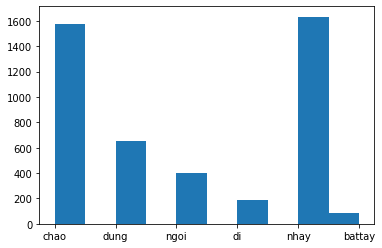

In [26]:
n, bins, patches = plt.hist(y)
plt.show()

### Feature extraction

In [27]:

def point_distance(X):
    d = np.zeros((n_samples, n_frame, n_point, 2))
    label = np.zeros((n_samples))
    for n in range(n_samples):
        # print(X[n,0, 13], X[n,0, 0])
        d_0_13 = np.linalg.norm(X[n,0, 13] - X[n,0, 0])
        # if (d_0_13<=0.01):
        #   print(d_0_13)
        for f in range(n_frame):
            for p in range(0, n_point):
                d[n, f, p] = (X[n, f, p] - X[n, 0, 0])/d_0_13

    return d
    

In [28]:
fps = 30

from scipy.spatial import distance

def speed(X):
    v = np.zeros((n_samples, n_frame-1, n_point, 2))
    cos = np.zeros((n_samples, n_frame-1, n_point))
    dis = np.zeros((n_samples, n_frame-1, n_point))
    time = 1/fps
    for n in range(n_samples):
        for f in range(n_frame-1):
            v[n,f] = (X[n,f+1] - X[n,f])/time
    for n in range(n_samples):
        for f in range(n_frame-1):
          for p in range(n_point):
              # cos[n,f,p] = 1 - distance.cosine(X[n,f+1,p] ,X[n,f,p])
              cos[n,f,p] = np.dot(X[n,f+1,p],X[n,f,p])/(np.linalg.norm(X[n,f+1,p])*np.linalg.norm(X[n,f,p]))
              dis[n,f,p] = np.linalg.norm(v[n,f,p])
    return v, cos, dis


In [29]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        y_pred = clf.predict(X_train)
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, y_pred)))
        # print("Classification Report: \n {}\n".format(classification_report(y_train, y_pred)))
        # print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, y_pred)))

        # res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        # print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        # print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n") 
        y_pred = clf.predict(X_test)
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, y_pred)))
        print("Classification Report: \n {}\n".format(classification_report(y_test, y_pred)))
        # print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_pred)))    
        

In [30]:
d = point_distance(X)

print(d.shape)

(4533, 30, 14, 2)


In [31]:
v, cos, dis = speed(d)
print(v.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


(4533, 29, 14, 2)


In [32]:
# fe_v = v.reshape((v.shape[0], v.shape[1]*v.shape[2]*v.shape[3]))
fe_d = d.reshape((d.shape[0], d.shape[1]*d.shape[2]*d.shape[3]))
fe_cos = cos.reshape((cos.shape[0], cos.shape[1]*cos.shape[2]))
fe_dis = dis.reshape((dis.shape[0], dis.shape[1]*dis.shape[2]))

print(fe_d.shape)
print(fe_cos.shape)
print(fe_dis.shape)

(4533, 840)
(4533, 406)
(4533, 406)


In [33]:
fe = np.hstack((fe_d, fe_cos, fe_dis))
print(fe.shape)

(4533, 1652)


In [34]:
np.isnan(fe).all() == False

True

### Train

In [35]:
import datetime
from xgboost import XGBClassifier

start =  datetime.datetime.now()

X_train, X_test, y_train, y_test = train_test_split(fe, y, test_size = 0.2, stratify=y)
xgb = XGBClassifier(max_depth=5, n_estimators=20, learning_rate=0.3, n_jobs=-1)
xgb.fit(X_train, y_train)

end =  datetime.datetime.now()
print('Time: ', end - start)

Time:  0:00:55.800116


### Test

In [36]:
start =  datetime.datetime.now()

print_score(xgb, X_train, y_train, X_test, y_test, train=False)

end =  datetime.datetime.now()
print('Time: ', end - start)

Test Result:

accuracy score: 0.9239

Classification Report: 
               precision    recall  f1-score   support

      battay       0.80      0.24      0.36        17
        chao       0.96      0.98      0.97       315
          di       0.72      0.35      0.47        37
        dung       0.77      0.88      0.82       130
        ngoi       0.93      0.99      0.96        81
        nhay       0.97      0.97      0.97       327

    accuracy                           0.92       907
   macro avg       0.86      0.73      0.76       907
weighted avg       0.92      0.92      0.92       907


Time:  0:00:00.069442


In [37]:
start =  datetime.datetime.now()

print_score(xgb, X_train, y_train, X_test, y_test, train=True)

end =  datetime.datetime.now()
print('Time: ', end - start)

Train Result:

accuracy score: 0.9997

Time:  0:00:00.157769


In [20]:
import pickle

pkl_filename = "xgb_norm_30f_d_cos_dis.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb, file)

In [ ]:
ACTION_MAP_ID = {
    0: 'sit down', # sit down
    1: 'stand up', # stand up
    2: 'jump', # jump
    3: 'hand shake', # hand shake
    4: 'walk', # walk
}